### QML 1. Running Primitive Unified Blocks (PUBs)  (SamplerV2 and EstimatorV2) & Satevector Simulator
For sampling the output of a circuit and estimating the expectation value of an observable


1. Both simple and paramteric circuits are exemplified.

2. The use of Aer Simulator is shown for both sampling and estimating the expectation value

3. We show how to use the IBM quantum computers from their latest cloud platform announced  on July 1, 2025 onwards

4. Statevector sampler and estimator syntax and implementation also shown.

If you are running this notebook in VS code, your environment must have the following libraries installed. If you are running this in google colab, you need to install the following libraries each time you initialize colab session.

`qiskit, qiskit-aer, qiskit-ibm-runtime, matplotlib, pylatexenc`

### Step 1. Link you IBM Quantum Cloud account
Make your account at [quantum.cloud.ibm.com](quantum.cloud.ibm.com) and make a new instant. Once you make the instant, copy the instant CRN and the API key (token) in the below cell. Name your account the way you want.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
token = "nDLD07y8TqS3jvE-zPIw4qV_tclN" # This is API key for IBM Quantum account. Get it from https://quantum-computing.ibm.com/account
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_cloud", # `channel` distinguishes between different account types.
  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/2f903a94d65c9-4077-b5fa-bf87972e20d0::", # Optionally copy the instance CRN or name from the Instance section on the dashboard.
  name="Faryad-free-ibm", # Optionally name this set of credentials.
  overwrite=True # Only needed if you already have Cloud credentials.
)

### Step 2. Load your IBM credential
Use the name you used above to load your credential and connect to a desired backend quantum computer

In [2]:
# Load saved credentials if you specified a name
ibm_service = QiskitRuntimeService(name="Faryad-free-ibm")
ibmq_comp = ibm_service.backend('ibm_torino')

Below we import AerSimulator

In [3]:
from qiskit_aer import AerSimulator
backend_aer = AerSimulator()


### Step 3. Instantiate samplers
Import sampler version 2 from IBM runtime and instantiate it for use with Aer Simulator and for use with IBM quantum computer. Sampler is used to measure (sample) the output of a circuit a desired number of time.

In [4]:
from qiskit_ibm_runtime import SamplerV2
sampler_aer = SamplerV2(mode=backend_aer)
sampler_ibm = SamplerV2(mode=ibmq_comp)

Create a circuit for sampling

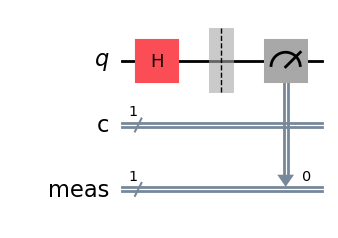

In [5]:
from qiskit import QuantumCircuit
qc1 = QuantumCircuit(1,1)
qc1.h(0)
qc1.measure_all()
qc1.draw('mpl')

### Step 4. Paramteric circuit
Create a paramteric circuit with your chosen names of classical and quantum registers. These names are used to access the qubits and classical bits

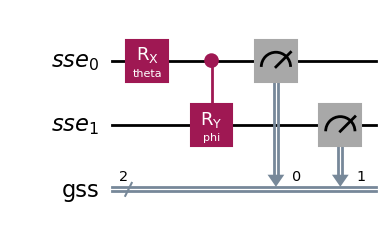

In [6]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
qr = QuantumRegister(2, name='sse')
cr = ClassicalRegister(2, name='gss')
theta=Parameter('theta')
phi=Parameter('phi')
qc2 = QuantumCircuit(qr, cr)
qc2.rx(theta, 0)
qc2.cry(phi, 0, 1)
qc2.measure(qr,cr)
qc2.draw('mpl')

To check the order of parameters for the circuit, use the following method

In [7]:
qc2.parameters

ParameterView([Parameter(phi), Parameter(theta)])

create an array of arrays of parameters 

In [8]:
from math import pi
angles = [[pi/2, pi/4], [pi/3, pi/6], [pi/4, pi/8], [pi/5, pi/10]]

### Step 5a. Transpile the circuit to use in the desired simulator

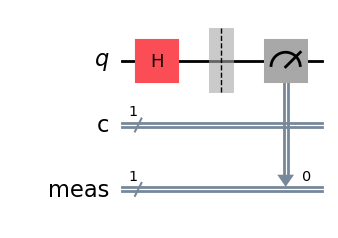

In [9]:
from qiskit import transpile
qc1_aer = transpile(qc1, backend_aer)
qc1_aer.draw('mpl')

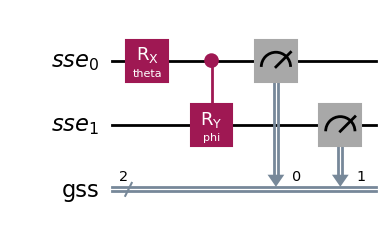

In [10]:
qc2_aer = transpile(qc2, backend=backend_aer)
qc2_aer.draw('mpl')

### Step 5b. Transpile the circuit to use on the desired quantum hardware

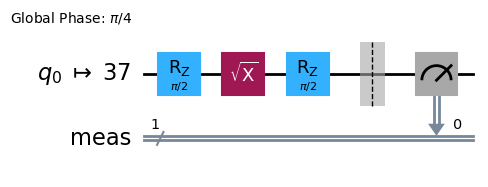

In [11]:
qc1_ibm = transpile(qc1, ibmq_comp)
qc1_ibm.draw('mpl',idle_wires=False)

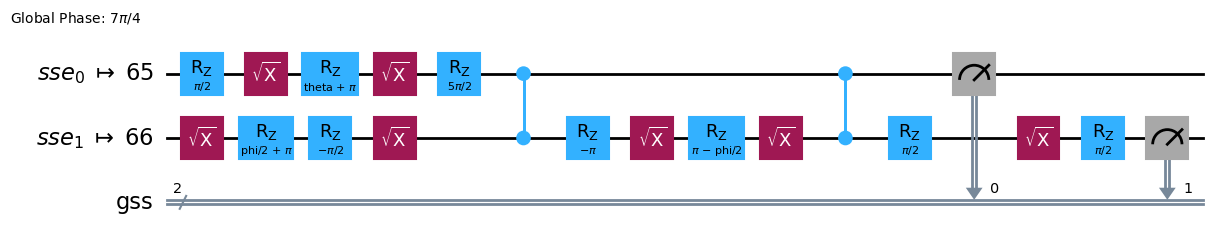

In [12]:
qc2_ibm = transpile(qc2, ibmq_comp)
qc2_ibm.draw('mpl',idle_wires=False)

### Step 6. Primitive Unified Blocks
We pass the blocks as (transpiled circuit, paramters array, number of shots) where shots is the number of times the circuit will be run again and sampled

In [13]:
job_aer = sampler_aer.run([(qc1_aer,None, 100), (qc2_aer,angles,1000)])  #PUBs on AER simulator
#job_ibm = sampler_ibm.run([(qc1_ibm,None, 100), (qc2_ibm,angles,1000)])    #PUBs on IBM quantum computer

use the .result() method to reterieve the results from the job

In [14]:
result_aer = job_aer.result()
#result_ibm = job_ibm.result()

### Step 7. Accesing the results
While accessing counts from the results, specify the PUB order, from 0 to n-1 in [] and the index of the paramter set from 0 to m-1 in (), if you n PUBs and m sets of parameters.

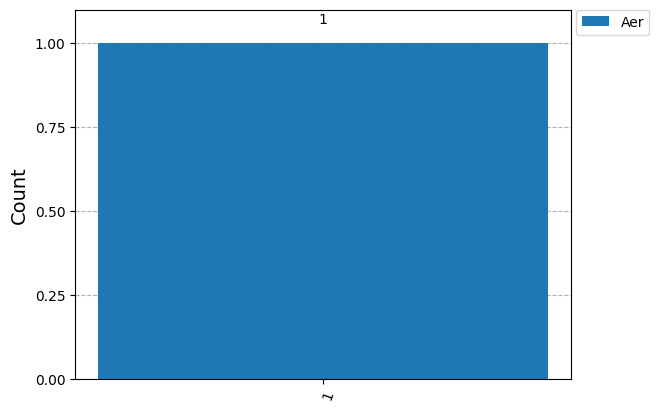

In [15]:
counts_qc1_aer = result_aer[0].data.meas.get_counts(0)
#counts_qc1_ibm = result_ibm[0].data.meas.get_counts(0)


from qiskit.visualization import plot_histogram, plot_distribution
plot_histogram([counts_qc1_aer], legend=['Aer'])

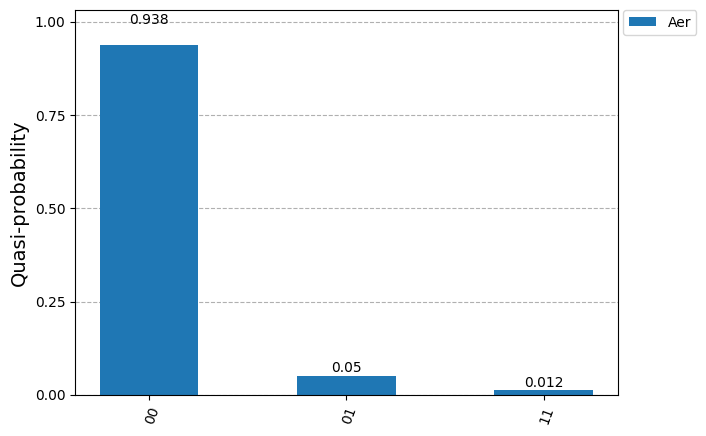

In [16]:
counts_qc2_aer = result_aer[1].data.gss.get_counts(1)
#counts_qc2_ibm = result_ibm[1].data.gss.get_counts(1)

plot_distribution([counts_qc2_aer], legend=['Aer'])

## Using Estimator V2 with IBM and Aer Simulator for estimating the expectation values of the observables

### Step 1. Observables Definition
Using SparsPauliOp you can specify Pauli observables as string of Pauli operators. 

In [17]:
from qiskit.quantum_info import SparsePauliOp
obsv_list = [[SparsePauliOp(["XX"],[1])],[SparsePauliOp(["ZZ"],[1])]]

### Step 2. Map observable layout
Since the transpiler has mapped circuit to specific qubits on the quantum computer, you need to map your logical observables to the qubits where circuit is mapped. For this purpose, extract the circuit layout and map your observables accordingly

In [18]:
layout = qc2_ibm.layout

obsv_ibm = [[obsv_list[0][0].apply_layout(layout)],[obsv_list[1][0].apply_layout(layout)]]
obsv_ibm

[[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
                coeffs=[1.+0.j])],
 [SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
                coeffs=[1.+0.j])]]

### Step 3. Using EstimatorV2
Import and instantiate Estimator version 2 to estimate the expectation values of the observables and specify the mode of operation.

In [19]:

from qiskit_ibm_runtime import EstimatorV2
estimator_aer = EstimatorV2(mode=backend_aer)
estimator_ibm = EstimatorV2(mode=ibmq_comp)

### Step 4. Estimator PUBs
Specify the blocks for estimator as (traspile circuit, mapped observables, array of paramters, tolerance in expecation value)
Note: The number of times that the ciruict is run to estimate the expectation value is proportional to $tolerance^{-2}$. So for a tolerance of $0.005$, the shots would be $40000$.

In [20]:
job2_aer = estimator_aer.run([(qc2_aer,obsv_list,angles, 0.005)])
#job2_ibm = estimator_ibm.run([(qc2_ibm,obsv_ibm,angles, 0.05)])

You can extract the expectation values using .evs methods by specifing the PUB index

In [21]:
exp_vals_aer = job2_aer.result()[0].data.evs
print(exp_vals_aer)

[[-1.9000e-03 -1.9000e-03 -2.2000e-03 -1.0000e-04]
 [ 8.5550e-01  8.9815e-01  9.3335e-01  9.5950e-01]]


If you submitted job to quantum computer a long time ago, you can access its result by secifying the job id as follow

In [22]:
#job2_ibm=QiskitRuntimeService().job('csy5rwbe88ng008q7bc0')

In [23]:
#exp_vals_ibm = job2_ibm.result()[0].data.evs
#print(exp_vals_ibm)

You can also check the standard deviation in the results of the expectation value using the .stds method

In [24]:
job2_aer.result()[0].data.stds

array([[0.00499999, 0.00499999, 0.00499999, 0.005     ],
       [0.00258901, 0.00219845, 0.00179484, 0.00140854]])

In [25]:
#job2_ibm.result()[0].data.stds

## Using State Vector Simulator for Sampling the output and Estimating the Expectation Values

### Step 1. Import and Instantiate Statevector Sampler and Estimation

In [26]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
SVsampler = StatevectorSampler()
SVestimator = StatevectorEstimator()

### Step 2.
Directly run the SV sampler and use PUB syntax for executing the circuit and accessing the results as before

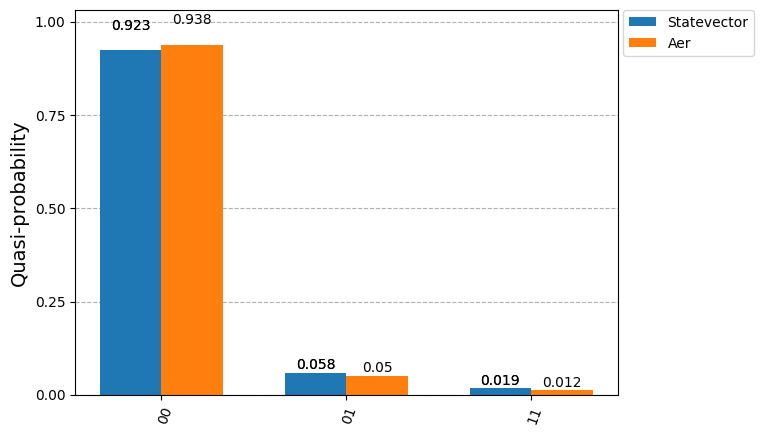

In [27]:
job_svs = SVsampler.run([(qc2,angles,1000),(qc2,angles,100)])
result_svs = job_svs.result()
counts_svs = result_svs[0].data.gss.get_counts(1)
plot_distribution([counts_svs, counts_qc2_aer], legend=['Statevector', 'Aer'])

### Step 3. No measurements for SV estimator
Remove the measurements from the qc2 circuit as SV estimator do not work if there are measurements at thend. So, we redraw the circuit.

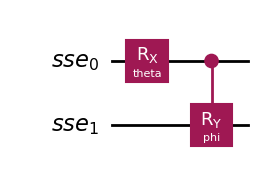

In [28]:
from qiskit import QuantumRegister
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
qr = QuantumRegister(2, name='sse')

qc2 = QuantumCircuit(qr)
qc2.rx(Parameter('theta'), 0)
qc2.cry(Parameter('phi'), 0, 1)
qc2.draw('mpl')

### Step 4.
Directly run the circuit with same PUB syntax as for estimator v2 above

In [29]:
job_sve = SVestimator.run([(qc2,obsv_list,angles,0.005)])
result_sve = job_sve.result()
exp_vals_sve = result_sve[0].data.evs

Both the Aer Simulator and SV simulator should give the same expectation values. We can see it by plotting them together againt the index of the sets of parameters.

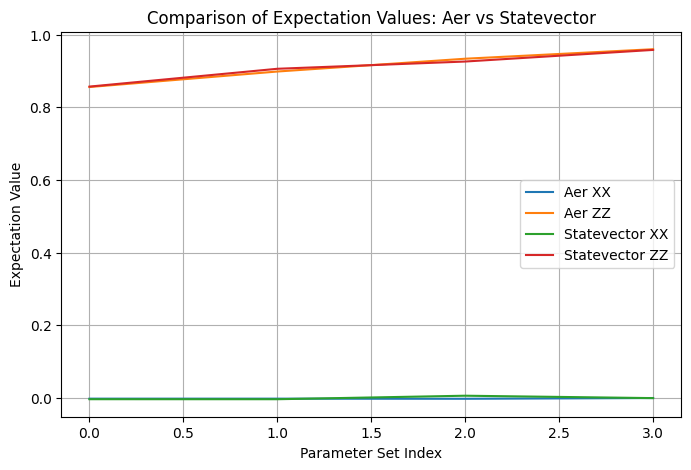

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for i, label in enumerate(['Aer', 'Statevector']):
    vals = exp_vals_aer if label == 'Aer' else exp_vals_sve
    plt.plot(vals[0], label=f'{label} XX')
    plt.plot(vals[1], label=f'{label} ZZ')

plt.xlabel('Parameter Set Index')
plt.ylabel('Expectation Value')
plt.title('Comparison of Expectation Values: Aer vs Statevector')
plt.legend()
plt.grid(True)
plt.show()

The notebook is based on materials from various sources. The syntax is according to qiskit version 2.3.

Please cite/acknowledge my work when you use this notebook. Thanks. M. Faryad. [github/muf18](github.com/muf148)